<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [502]:
import numpy as np
import pandas as pd
import patsy
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

from sklearn.linear_model import (LinearRegression, LogisticRegression, 
                                  Lasso, Ridge,
                                  SGDRegressor, SGDClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import grid_search

from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats

In [168]:
filen = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/businesses_small_parsed.csv'
filen2 = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/checkins_small_parsed.csv'
filen3 = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv'
filen4 = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/users_small_parsed.csv'
filen5 = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv'

business = pd.read_csv(filen)
checkins = pd.read_csv(filen2)
revs = pd.read_csv(filen3)
users = pd.read_csv(filen4)
tips = pd.read_csv(filen5)

In [430]:
filen4 = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/datasets/yelp_arizona_data/users_small_parsed.csv'
users = pd.read_csv(filen4)


In [12]:
checkins.head(2)

,business_id,variable,value
0,SG_gEmEXL4ID6RAEinC5Bg,checkin_info.9-0,1.0
1,45puCRQ6Vh_IIAy7kkfFDQ,checkin_info.9-0,1.0


In [374]:
business.dtypes

business_id       object
name              object
review_count       int64
city              object
stars            float64
categories        object
latitude         float64
longitude        float64
neighborhoods     object
variable          object
value             object
dtype: object

In [169]:
business.shape

(152832, 11)

In [170]:
bus_vars = pd.pivot_table(business,columns=['variable'], values='value', index=['business_id','review_count','stars', 'city','categories'], 
                          aggfunc=lambda x: " ".join([str(y) for y in x])).reset_index()

In [192]:
bus_vars['is_vegas'] = bus_vars['city'].apply(lambda x: 1 if x=='Las Vegas' else 0)
bus_vars.drop('city', axis=1,inplace=True)
bus_vars.shape

(4132, 83)

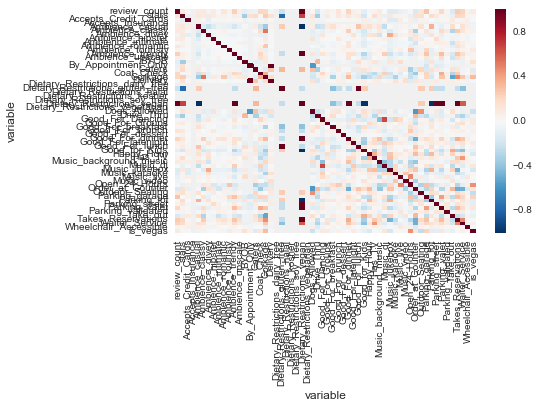

In [180]:
bus_vars.rename(columns=lambda x: x.strip().replace(" ", "_").replace(".", "_").replace("-", "_").replace("attributes_", ""), inplace=True)

features = [x for x in bus.columns if x not in 'is_vegas']
for f in features[4:]:
    bus_vars[f] = bus_vars[f].apply(lambda x: 0 if x=='False' else 1 if x=='True' else x)

sns.heatmap(bus_vars.corr())

In [181]:
bus_vars.columns.values

array(['business_id', 'review_count', 'stars', 'categories',
       'Accepts_Credit_Cards', 'Accepts_Insurance', 'Ages_Allowed',
       'Alcohol', 'Ambience_casual', 'Ambience_classy', 'Ambience_divey',
       'Ambience_hipster', 'Ambience_intimate', 'Ambience_romantic',
       'Ambience_touristy', 'Ambience_trendy', 'Ambience_upscale',
       'Attire', 'BYOB', 'BYOB/Corkage', 'By_Appointment_Only', 'Caters',
       'Coat_Check', 'Corkage', 'Delivery',
       'Dietary_Restrictions_dairy_free',
       'Dietary_Restrictions_gluten_free', 'Dietary_Restrictions_halal',
       'Dietary_Restrictions_kosher', 'Dietary_Restrictions_soy_free',
       'Dietary_Restrictions_vegan', 'Dietary_Restrictions_vegetarian',
       'Dogs_Allowed', 'Drive_Thru', 'Good_For_Dancing', 'Good_For_Groups',
       'Good_For_breakfast', 'Good_For_brunch', 'Good_For_dessert',
       'Good_For_dinner', 'Good_For_latenight', 'Good_For_lunch',
       'Good_for_Kids', 'Happy_Hour', 'Has_TV', 'Music_background_music',
 

In [218]:
bus_vars.shape

(4132, 83)

In [228]:
fe = ['Dietary_Restrictions_gluten_free', 'Dietary_Restrictions_vegan', 'Corkage', 'Ambience_casual', 'Dogs_Allowed', 'BYOB', 'Delivery', 'Ambience_hipster', 'Ambience_touristy']
for f in fe:
    bus_vars[f] = bus_vars[f].apply(lambda x: 1 if x==1 else 0)


In [376]:
veg_piv = bus_vars.groupby(['is_vegas'])[['Dietary_Restrictions_gluten_free', 'Dietary_Restrictions_vegan', 'Corkage', 'Ambience_casual', 'Dogs_Allowed', 'BYOB', 'Delivery', 'Ambience_hipster', 'Ambience_touristy']].sum().reset_index()
veg_piv.head()

variable,is_vegas,Dietary_Restrictions_gluten_free,Dietary_Restrictions_vegan,Corkage,Ambience_casual,Dogs_Allowed,BYOB,Delivery,Ambience_hipster,Ambience_touristy
0,0,1,1,2,501,76,0,97,32,3
1,1,0,0,20,752,52,3,125,52,45


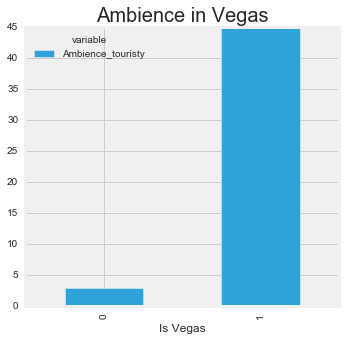

In [397]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()

veg_piv[['Ambience_touristy']].plot.bar(stacked=True, ax=ax)

ax.set_title('Ambience in Vegas', fontsize=20)
ax.set_xticklabels(veg_piv.is_vegas)
ax.set_xlabel('Is Vegas')
plt.show()


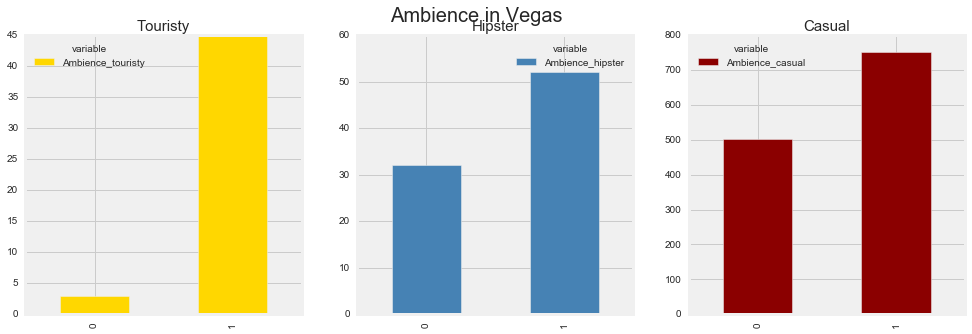

In [416]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 3, figsize=(15,5))

# ax[0] = sns.barplot(veg_piv['Ambience_touristy'],  color='gold', ax=ax[0])
# ax[1] = sns.barplot(veg_piv['Ambience_hipster'],  color='steelblue', ax=ax[1])
# ax[2] = sns.barplot(veg_piv['Ambience_casual'],  color='darkred', ax=ax[2])

ax[0] = veg_piv[['Ambience_touristy']].plot(kind='bar',  color='gold', ax=ax[0])
ax[1] = veg_piv[['Ambience_hipster']].plot(kind='bar',  color='steelblue', ax=ax[1])
ax[2] = veg_piv[['Ambience_casual']].plot(kind='bar',  color='darkred', ax=ax[2])

ax[0].set_title('Touristy', fontsize=15)
ax[1].set_title('Hipster', fontsize=15)
ax[2].set_title('Casual', fontsize=15)

plt.suptitle('Ambience in Vegas \n', fontsize=20)

plt.show()

In [187]:
formula = 'is_vegas ~ stars + review_count + Dietary_Restrictions_gluten_free + Dietary_Restrictions_vegan + Corkage + Ambience_casual + Dogs_Allowed + BYOB + Delivery + Ambience_hipster + Ambience_touristy -1'
print formula


is_vegas ~ stars + review_count + Dietary_Restrictions_gluten_free + Dietary_Restrictions_vegan + Corkage + Ambience_casual + Dogs_Allowed + BYOB + Delivery + Ambience_hipster + Ambience_touristy -1


In [229]:
bus_vars['Corkage'].unique()

array([0, 1])

In [230]:
y = bus_vars['is_vegas']
X = bus_vars[['stars', 'review_count', 'Dietary_Restrictions_gluten_free', 'Dietary_Restrictions_vegan', 'Corkage', 'Ambience_casual', 'Dogs_Allowed', 'BYOB', 'Delivery', 'Ambience_hipster', 'Ambience_touristy']].values
y = y.values.ravel()

print y.shape,X.shape

(4132,) (4132, 11)


In [231]:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [235]:
cv_indices = StratifiedKFold(y, n_folds=5)

logreg = LogisticRegression()

lr_scores = []


for train_inds, test_inds in cv_indices:
    
    X_train, y_train = X[train_inds, :], y[train_inds]
    X_test, y_test = X[test_inds, :], y[test_inds]
    
    logreg.fit(X_train, y_train)
    lr_scores.append(logreg.score(X_test, y_test))
    
print lr_scores
print 'Mean score: ', np.mean(lr_scores)

print 'Baseline accuracy:', np.mean(y)

[0.62756952841596125, 0.61910519951632403, 0.62590799031476996, 0.62832929782082325, 0.63075060532687655]
Mean score:  0.626332524279
Baseline accuracy: 0.621974830591


In [ ]:
['Dietary_Restrictions_gluten_free', 'Dietary_Restrictions_vegan', 'Corkage', 'Ambience_casual', 'Dogs_Allowed', 
 'BYOB', 'Delivery', 'Ambience_hipster', 'Ambience_touristy']

Are you a casual hipster looking to tourist about soon? Bring your dog and your gluten-free, vegan tastes to Vegas.
You can bring your own artisan wine for a corkage fee or have local varietals delivered to you. Vegas, come be
your very randomly specific self here.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to adm
it that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [281]:
revs.head(2)

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10_minutes,15_minutes,...,time_vegas,try_place,ve_seen,ve_tried,wait_staff,avg_total_service,avg_total_food,service_over_food,service_count,food_count
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0.0,0.0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0.0,0.0,0,0,0


In [243]:
revs.columns.values

array(['user_id', 'review_id', 'votes.cool', 'business_id', 'votes.funny',
       'stars', 'date', 'votes.useful', '10_minutes', '15_minutes',
       '20_minutes', '30_minutes', 'bar_food', 'beer_selection', 'best_ve',
       'bloody_mary', 'bottle_service', 'chicken_waffles',
       'customer_service', 'dance_floor', 'decided_try', 'definitely_come',
       'definitely_recommend', 'didn_want', 'don_know', 'don_like',
       'don_think', 'don_want', 'eggs_benedict', 'fast_food', 'feel_like',
       'felt_like', 'fish_chips', 'food_amazing', 'food_came',
       'food_delicious', 'food_good', 'food_great', 'food_just',
       'food_service', 'french_fries', 'french_toast', 'friday_night',
       'fried_chicken', 'friendly_staff', 'good_food', 'good_place',
       'good_service', 'good_thing', 'good_time', 'great_atmosphere',
       'great_experience', 'great_food', 'great_place', 'great_service',
       'great_time', 'happy_hour', 'hash_browns', 'highly_recommend',
       'hip_hop', 'ice

In [310]:
revs.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

In [312]:
revs['service_count'] = 0
revs['food_count'] = 0

food = ['food_delicious', 'food_good', 'food_great','great_food','quality_food',
        'food_amazing','good_food','really_enjoyed', 'really_good']
serv = ['good_service','customer_service','great_service','service_excellent','service_food',
        'service_friendly', 'service_good', 'service_great','staff_friendly']

for s in serv:
    revs['service_count'] = revs['service_count'] + np.where(revs[s] > 0, 1, 0)
    
for f in food:
    revs['food_count'] = revs['food_count'] + np.where(revs[f] > 0, 1, 0)



In [314]:
revs['service_over_food'] =  np.where(revs['service_count'] > revs['food_count'], 1, 0)

In [315]:
revs[revs.food_count == 4][food].head(4)

,food_delicious,food_good,food_great,great_food,quality_food,food_amazing,good_food,really_enjoyed,really_good
6005,0,2,1,1,0,0,1,0,0
19002,0,1,0,1,0,0,1,0,1
30527,0,1,0,1,0,0,1,0,1
32384,0,1,1,1,0,0,0,0,1


In [316]:
revs[revs.service_over_food == 1].head(4)

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10_minutes,15_minutes,...,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff,service_count,food_count,service_over_food
18,tm3vOevmVh6EQlcWNV6Xug,e3LPy75TialrhqsRMH0PYw,0,EmzaQR5hQlF0WIl24NxAZA,0,5,2014-05-21,1,0,0,...,0,0,0,0,0,0,0,1,0,1
43,N-D-d1Z4UybdlkK1HxlNPA,n1c9Qyb-A9gVjtOCbWz4xw,0,e5kc0CQ4R-PCCDgb274gSg,0,4,2007-02-25,0,0,0,...,0,0,0,0,0,0,0,1,0,1
49,HOleI3jz1MLNUJ6cc1x0Pw,8EwBq6JDbL3-G5harQcbgw,0,e5kc0CQ4R-PCCDgb274gSg,3,2,2008-06-29,3,1,0,...,0,0,0,0,0,0,0,2,1,1
61,4dnDsoHuxUtzhaumxbpR5w,SgKZrdPZGz6pV1-pZpPQAw,1,e5kc0CQ4R-PCCDgb274gSg,1,2,2009-05-31,2,0,0,...,0,1,0,0,0,0,0,1,0,1


In [319]:
service_lean = (revs['service_over_food']==1)
food_lean = (revs['service_over_food']==0)

In [354]:
rev_serv = revs[service_lean].groupby(['business_id','stars'])[['good_service','customer_service','great_service',
                                        'service_excellent','service_food','service_friendly', 'service_good', 
                                         'service_great','staff_friendly','food_delicious', 'food_good', 'food_great','great_food','quality_food',
                              'food_amazing','good_food','really_enjoyed', 'really_good']].sum().reset_index()
rev_serv.head()

,business_id,stars,good_service,customer_service,great_service,service_excellent,service_food,service_friendly,service_good,service_great,staff_friendly,food_delicious,food_good,food_great,great_food,quality_food,food_amazing,good_food,really_enjoyed,really_good
0,--jFTZmywe7StuZ2hEjxyA,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,--jFTZmywe7StuZ2hEjxyA,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0HGqwlfw3I8nkJyMHxAsQ,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0HGqwlfw3I8nkJyMHxAsQ,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,3,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [355]:
rev_food = revs[food_lean].groupby(['business_id','stars'])[['good_service','customer_service','great_service',
                                        'service_excellent','service_food','service_friendly', 'service_good', 
                                         'service_great','staff_friendly','food_delicious', 'food_good', 'food_great','great_food','quality_food',
                              'food_amazing','good_food','really_enjoyed', 'really_good']].sum().reset_index()
rev_food.head()

,business_id,stars,good_service,customer_service,great_service,service_excellent,service_food,service_friendly,service_good,service_great,staff_friendly,food_delicious,food_good,food_great,great_food,quality_food,food_amazing,good_food,really_enjoyed,really_good
0,--jFTZmywe7StuZ2hEjxyA,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,--jFTZmywe7StuZ2hEjxyA,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0HGqwlfw3I8nkJyMHxAsQ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0HGqwlfw3I8nkJyMHxAsQ,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0HGqwlfw3I8nkJyMHxAsQ,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [356]:
ys = np.ravel(rev_serv['stars'].values)
Xs = rev_serv[['food_delicious', 'food_good', 'food_great','great_food','quality_food','food_amazing','good_food','really_enjoyed', 'really_good','good_service','customer_service','great_service',
                'service_excellent','service_food','service_friendly', 'service_good', 'service_great','staff_friendly']]
yf = np.ravel(rev_food['stars'].values)
Xf = rev_food[['food_delicious', 'food_good', 'food_great','great_food','quality_food','food_amazing','good_food','really_enjoyed', 'really_good','good_service','customer_service','great_service',
                'service_excellent','service_food','service_friendly', 'service_good', 'service_great','staff_friendly']]

In [357]:
ss = StandardScaler()
Xsn = ss.fit_transform(Xs)
Xfn = ss.fit_transform(Xf)

In [358]:
alphas = np.linspace(0.001,10,100)

In [367]:
params = {
    'alpha': alphas
}
lasso = Lasso()
lasso_gridsearcher = grid_search.GridSearchCV(lasso, params, cv=5, verbose=1)
results = lasso_gridsearcher.fit(Xsn, ys)

best_lasso = lasso_gridsearcher.best_estimator_

lasso_scores = cross_val_score(best_lasso, Xsn, ys, cv=5)


lasso_coefs = pd.DataFrame({'variable':Xs.columns,
                            'coef':best_lasso.coef_,
                            'abs_coef':np.abs(best_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print lasso_scores
print np.mean(lasso_scores)
print
print "Best Params: ", lasso_gridsearcher.best_params_
print "Best Score: ", lasso_gridsearcher.best_score_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.0s


[ 0.09168559  0.13491878  0.09939168  0.13869555  0.14523668]
0.121985656117

Best Params:  {'alpha': 0.001}
Best Score:  0.1219834885


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished


In [368]:
params = {
    'alpha': alphas
}
lasso_f = Lasso()
lasso_gridsearcher_f = grid_search.GridSearchCV(lasso_f, params, cv=5, verbose=1)
results_f = lasso_gridsearcher_f.fit(Xfn, yf)

best_lasso_f = lasso_gridsearcher_f.best_estimator_

lasso_scores_f = cross_val_score(best_lasso_f, Xfn, yf, cv=5)


lasso_coefs_f = pd.DataFrame({'variable':Xf.columns,
                            'coef':best_lasso_f.coef_,
                            'abs_coef':np.abs(best_lasso_f.coef_)})

lasso_coefs_f.sort_values('abs_coef', inplace=True, ascending=False)

print lasso_scores_f
print np.mean(lasso_scores_f)
print
print "Best Params: ", lasso_gridsearcher_f.best_params_
print "Best Score: ", lasso_gridsearcher_f.best_score_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.0s finished


[ 0.03043349  0.05682476  0.0414597   0.0555832   0.06207436]
0.0492751017639

Best Params:  {'alpha': 0.001}
Best Score:  0.0492743104161


In [370]:
print "Top 5 coefficients for Food leaning reviews: "
print lasso_coefs_f.head()
print
print "Top 5 coefficients for Service leaning reviews: "
print lasso_coefs.head()


Top 5 coefficients for Food leaning reviews: 
   abs_coef      coef        variable
3  0.326112  0.326112      great_food
8  0.159984  0.159984     really_good
4  0.157362 -0.157362    quality_food
7  0.122675  0.122675  really_enjoyed
1  0.122563 -0.122563       food_good

Top 5 coefficients for Service leaning reviews: 
    abs_coef      coef          variable
11  0.430768  0.430768     great_service
17  0.381245  0.381245    staff_friendly
13  0.273817 -0.273817      service_food
10  0.261187 -0.261187  customer_service
9   0.132231 -0.132231      good_service


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [475]:
users.head(2)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483


In [448]:
# restricting dataset to users who have been elite for the last 4 years without interruption
lately = (users.elite == '[2012, 2013, 2014, 2015]')
users_working = users[lately]
users_working['is_elite'] = 1

/Users/katbishop/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [473]:
#dataset of users who have been yelping but not elite since 2012
not_elite = ((users.elite == '[]') & (users.yelping_since.str.contains('2012') ))
users_not_elite = users[not_elite]
users_not_elite['is_elite'] = 0

/Users/katbishop/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [487]:
users_sub = pd.concat([users_working,users_not_elite])
users_sub.head(2)
users_sub.shape

(21496, 22)

In [479]:
users_sub.columns.values

array(['yelping_since', 'compliments.plain', 'review_count',
       'compliments.cute', 'compliments.writer', 'fans',
       'compliments.note', 'compliments.hot', 'compliments.cool',
       'compliments.profile', 'average_stars', 'compliments.more', 'elite',
       'name', 'user_id', 'votes.cool', 'compliments.list', 'votes.funny',
       'compliments.photos', 'compliments.funny', 'votes.useful',
       'is_elite'], dtype=object)

In [489]:
users_sub['compliments.plain'].isnull().sum()
users_sub.fillna(0, inplace=True)

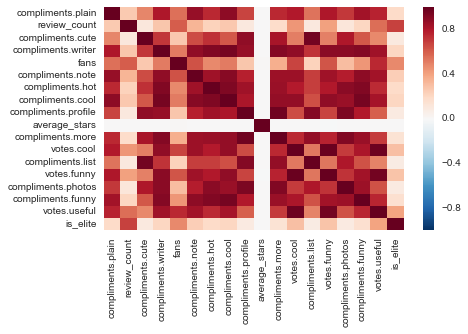

In [493]:
sns.heatmap(users_sub.corr())

In [506]:
# sns.pairplot(data=users_sub,
#              hue="is_elite", 
#              plot_kws=dict(alpha=0.3))

In [494]:
# including counts
y = np.ravel(users_sub['is_elite'].values)
X = users_sub[['compliments.plain', 'review_count','compliments.cute', 'compliments.writer', 'fans','compliments.note',
               'compliments.hot', 'compliments.cool','compliments.profile', 'compliments.more',
               'votes.cool', 'compliments.list', 'votes.funny','compliments.photos', 'compliments.funny', 'votes.useful']]

print y.shape, X.shape

(21496,) (21496, 16)


In [495]:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [500]:
lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 10, 2)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

lr_gs.fit(Xn, y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.4min finished


{'penalty': 'l2', 'C': 10.0, 'solver': 'liblinear'}


In [504]:
params = {
    'n_neighbors':range(1,10),
    'weights':['uniform','distance']
}
knn_gs = GridSearchCV(KNeighborsClassifier(), params, cv=5, verbose=1)

knn_gs.fit(Xn, y)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   43.1s


{'n_neighbors': 9, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


In [505]:
cv_indices = StratifiedKFold(y, n_folds=5)

lr_scores = []
knn_scores = []

for train_inds, test_inds in cv_indices:
    
    Xtr, ytr = Xn[train_inds, :], y[train_inds]
    Xte, yte = Xn[test_inds, :], y[test_inds]
    
    best_knn.fit(Xtr, ytr)
    knn_scores.append(best_knn.score(Xte, yte))
    
    best_lr.fit(Xtr, ytr)
    lr_scores.append(best_lr.score(Xte, yte))
    
print 'KNN:'
print knn_scores
print np.mean(knn_scores)

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

print 'Baseline accuracy:', np.mean(y)

KNN:
[0.9893023255813953, 0.98790697674418604, 0.99139534883720926, 0.98790134946486741, 0.98813401582131222]
0.98892800329
Logistic Regression:
[0.98837209302325579, 0.98720930232558135, 0.9851162790697674, 0.98464402047463939, 0.98557468590041875]
0.986183276159
Baseline accuracy: 0.0734090063268


In [508]:
users_sub[['is_elite','fans','average_stars']].corr()

,is_elite,fans,average_stars
is_elite,1.000000,0.479129,0.007644
fans,0.479129,1.000000,0.015017
average_stars,0.007644,0.015017,1.000000


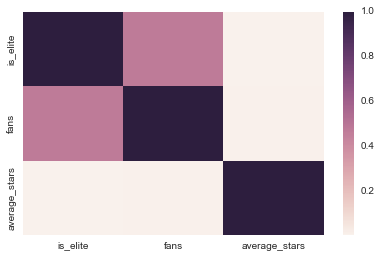

In [509]:
sns.heatmap(users_sub[['is_elite','fans','average_stars']].corr())

In [510]:
# removing counts
y2 = np.ravel(users_sub['is_elite'].values)
X2 = users_sub[['fans','average_stars']]

print y.shape, X.shape

(21496,) (21496, 16)


In [511]:
X2n = ss.fit_transform(X2)

In [512]:
arams = {
    'n_neighbors':range(1,10),
    'weights':['uniform','distance']
}
knn_gs = GridSearchCV(KNeighborsClassifier(), params, cv=5, verbose=1)

knn_gs.fit(X2n, y)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    8.9s


{'n_neighbors': 7, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   15.6s finished


In [513]:
knn_scores = []

for train_inds, test_inds in cv_indices:
    
    Xtr, ytr = Xn[train_inds, :], y[train_inds]
    Xte, yte = Xn[test_inds, :], y[test_inds]
    
    best_knn.fit(Xtr, ytr)
    knn_scores.append(best_knn.score(Xte, yte))
    
    
print 'KNN:'
print knn_scores
print np.mean(knn_scores)


print 'Baseline accuracy:', np.mean(y)

KNN:
[0.98906976744186048, 0.98767441860465122, 0.9909302325581395, 0.98836668217775714, 0.98766868310842248]
0.988741956778
Baseline accuracy: 0.0734090063268


In [ ]:
# The accuracty is similar. Which means that either both sets of models are crummy or that fans is the
# major predictor

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?